<a href="https://colab.research.google.com/github/greyhound101/gan_segmentation_FE/blob/main/3d_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [5]:
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/segmentation/Training_Batch1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [6]:
pip install medpy

  Using cached https://files.pythonhosted.org/packages/3b/70/c1fd5dd60242eee81774696ea7ba4caafac2bad8f028bba94b1af83777d7/MedPy-0.4.0.tar.gz
     |████████████████████████████████| 47.4MB 64kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754450 sha256=e378f6587aad95aad3dc9ba52837382b53e82b196e5c99fedee7eee1d94c08e3
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [7]:
import os
import glob
for i in range(6,28):
    os.remove( '/content/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-'+str(i)+'.nii')
    os.remove( '/content/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-'+str(i)+'.nii')

In [8]:
import os
os.mkdir('data')

In [9]:
from medpy.io import load, save
import os
import os.path
import gc
from scipy.ndimage import zoom
import numpy as np
from tqdm import tqdm
for file in tqdm(range(6)):
        shape=4/2
        img, img_header = load('/content/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-'+str(file)+'.nii')
        seg, img_header = load('/content/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-'+str(file)+'.nii')
        arr=np.where(seg==2)[-1]
        mn=(arr.min()+arr.max())/2
        
        
        if mn-shape<0:
          start=0
          end=shape*2
        elif mn+shape>img.shape[-1]:
          end=img.shape[-1]
          start=end-shape*2
        else:
          start=int(max(0,(mn-shape)))
          end=int(min(img.shape[-1],int(mn+shape)))
        
        
        img=img[:,:,start:end]
        img[img < -200] = -200
        img[img > 250] = 250
        img+=112
        img/=117
        img = np.array(img, dtype='float32')
        print ("Saving image "+str(file))
        np.save( "/content/data/volume-" + str(file) ,zoom(img, (0.125, 0.125, 1)))
        print(img.shape)
        del([img])
        gc.collect()
        seg=seg.astype('float64')
        seg+=0.1645
        seg/=0.023138
        seg = np.array(seg, dtype='float32')
        seg=seg[:,:,start:end]
        # print ("Saving image "+file)
        np.save( "/content/data/segmentation-" + str(file),zoom(seg, (0.125, 0.125, 1)))
        del([seg])
        gc.collect()

  0%|          | 0/6 [00:00<?, ?it/s]

Saving image 0
(512, 512, 4)


 17%|█▋        | 1/6 [00:02<00:13,  2.77s/it]

Saving image 1
(512, 512, 4)


 33%|███▎      | 2/6 [00:06<00:11,  2.95s/it]

Saving image 2
(512, 512, 4)


 50%|█████     | 3/6 [00:21<00:20,  6.79s/it]

Saving image 3
(512, 512, 4)


 67%|██████▋   | 4/6 [00:29<00:14,  7.11s/it]

Saving image 4
(512, 512, 4)


 83%|████████▎ | 5/6 [00:49<00:10, 10.76s/it]

Saving image 5
(512, 512, 4)


100%|██████████| 6/6 [00:57<00:00,  9.59s/it]


In [9]:
import scipy.ndimage as nd
import scipy.io as io
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import skimage.measure as sk
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
import numpy as np
from torch.utils import data
from torch.autograd import Variable
import torch
import os
import pickle

def getVoxelFromMat(path, cube_len=64):

    voxels = io.loadmat(path)['instance']
    voxels = np.pad(voxels, (1, 1), 'constant', constant_values=(0, 0))
    if cube_len != 32 and cube_len == 64:
        voxels = nd.zoom(voxels, (2, 2, 2), mode='constant', order=0)
    return voxels


def getVFByMarchingCubes(voxels, threshold=0.5):
    """Voxel 로 부터 Vertices, faces 리턴 하는 함수"""
    v, f = sk.marching_cubes_classic(voxels, level=threshold)
    return v, f


def plotVoxelVisdom(voxels, visdom, title):
    v, f = getVFByMarchingCubes(voxels)
    visdom.mesh(X=v, Y=f, opts=dict(opacity=0.5, title=title))


def plotFromVoxels(voxels):
    z, x, y = voxels.nonzero()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, -z, zdir='z', c='red')
    plt.show()


def SavePloat_Voxels(voxels, path, iteration):
    voxels = voxels[:8].__ge__(0.5)
    fig = plt.figure(figsize=(32, 16))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(voxels):
        x, y, z = sample.nonzero()
        ax = plt.subplot(gs[i], projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
    plt.savefig(path + '/{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
    plt.close()

    with open(path + '/{}.pkl'.format(str(iteration).zfill(3)), "wb") as f:
        pickle.dump(voxels, f, protocol=pickle.HIGHEST_PROTOCOL)


def make_hyparam_string(hyparam_dict):
    str_result = ""
    for i in hyparam_dict.keys():
        str_result = str_result + str(i) + "=" + str(hyparam_dict[i]) + "_"
    return str_result[:-1]

class ShapeNetDataset(data.Dataset):
    """Custom Dataset compatible with torch.utils.data.DataLoader"""

    def __init__(self):
      pass
    def __getitem__(self, index):
        seg=np.load('/content/data/segmentation-'+str(index)+'.npy')
        img=np.load('/content/data/volume-'+str(index)+'.npy')
        total=np.concatenate([img,seg],-1)

        return torch.FloatTensor(total)

    def __len__(self):
        return 6

def var_or_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def generateZ():

    Z = var_or_cuda(torch.Tensor(1,1024).normal_(0, 0.33))

    return Z

########################## Pickle helper ###############################


def read_pickle(path, G, G_solver, D_, D_solver):
    try:

        files = os.listdir(path)
        file_list = [int(file.split('_')[-1].split('.')[0]) for file in files]
        file_list.sort()
        recent_iter = str(file_list[-1])
        print(recent_iter, path)

        with open(path + "/G_" + recent_iter + ".pkl", "rb") as f:
            G.load_state_dict(torch.load(f))
        with open(path + "/G_optim_" + recent_iter + ".pkl", "rb") as f:
            G_solver.load_state_dict(torch.load(f))
        with open(path + "/D_" + recent_iter + ".pkl", "rb") as f:
            D_.load_state_dict(torch.load(f))
        with open(path + "/D_optim_" + recent_iter + ".pkl", "rb") as f:
            D_solver.load_state_dict(torch.load(f))


    except Exception as e:

        print("fail try read_pickle", e)



def save_new_pickle(path, iteration, G, G_solver, D_, D_solver):
    if not os.path.exists(path):
        os.makedirs(path)

    with open(path + "/G_" + str(iteration) + ".pkl", "wb") as f:
        torch.save(G.state_dict(), f)
    with open(path + "/G_optim_" + str(iteration) + ".pkl", "wb") as f:
        torch.save(G_solver.state_dict(), f)
    with open(path + "/D_" + str(iteration) + ".pkl", "wb") as f:
        torch.save(D_.state_dict(), f)
    with open(path + "/D_optim_" + str(iteration) + ".pkl", "wb") as f:
        torch.save(D_solver.state_dict(), f)

In [10]:
import torch


class _G(torch.nn.Module):
    def __init__(self):
        super(_G, self).__init__()
        self.cube_len = 64

        padd = (0, 0, 0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(1024, self.cube_len*8, kernel_size=4, stride=2, padding=padd),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len*8, self.cube_len*4, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len*4, self.cube_len*2, kernel_size=4, stride=2, padding='same'),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(16, 32, kernel_size=4, stride=2, padding='same'),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(32,8, kernel_size=4, stride=2, padding='same')
        )
        self.lnr = torch.nn.Linear(1024,8*1024)
    def forward(self, x):
        x = self.lnr(x)
        out = x.view(-1, 8, 32, 32, 1)
        #print(out.size())  # torch.Size([100, 200, 1, 1, 1])
        out = self.layer1(out)
        #print(out.size())  # torch.Size([100, 512, 4, 4, 4])
        out = self.layer2(out)
        #print(out.size())  # torch.Size([100, 256, 8, 8, 8])
        out = self.layer3(out)
        #print(out.size())  # torch.Size([100, 128, 16, 16, 16])
        out = self.layer4(out)
        #print(out.size())  # torch.Size([100, 64, 32, 32, 32])
        out = self.layer5(out)
        #print(out.size())  # torch.Size([100, 1, 64, 64, 64])

        return out


class _D(torch.nn.Module):
    def __init__(self, ):
        super(_D, self).__init__()
        self.cube_len = 64

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, padding=padd),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        out = x.view(-1, 1, 64,64,8)
        #print(out.size()) # torch.Size([100, 1, 64, 64, 64])
        out = self.layer1(out)
        #print(out.size())  # torch.Size([100, 64, 32, 32, 32])
        out = self.layer2(out)
        #print(out.size())  # torch.Size([100, 128, 16, 16, 16])
        out = self.layer3(out)
        #print(out.size())  # torch.Size([100, 256, 8, 8, 8])
        out = self.layer4(out)
        #print(out.size())  # torch.Size([100, 512, 4, 4, 4])
        out = self.layer5(out)
        #print(out.size())  # torch.Size([100, 200, 1, 1, 1])

        return out

In [11]:
from bisect import bisect_right
from torch.optim.optimizer import Optimizer


class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch + 1)
        self.last_epoch = last_epoch

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr


class LambdaLR(_LRScheduler):
    def __init__(self, optimizer, lr_lambda, last_epoch=-1):
        self.optimizer = optimizer
        if not isinstance(lr_lambda, list) and not isinstance(lr_lambda, tuple):
            self.lr_lambdas = [lr_lambda] * len(optimizer.param_groups)
        else:
            if len(lr_lambda) != len(optimizer.param_groups):
                raise ValueError("Expected {} lr_lambdas, but got {}".format(
                    len(optimizer.param_groups), len(lr_lambda)))
            self.lr_lambdas = list(lr_lambda)
        self.last_epoch = last_epoch
        super(LambdaLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * lmbda(self.last_epoch)
                for lmbda, base_lr in zip(self.lr_lambdas, self.base_lrs)]


class StepLR(_LRScheduler):
    """Sets the learning rate of each parameter group to the initial lr
    decayed by gamma every step_size epochs.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
    Example:
        >>> # Assuming optimizer uses lr = 0.5 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 60
        >>> # lr = 0.0005   if 60 <= epoch < 90
        >>> # ...
        >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>     validate(...)
    """

    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]


class MultiStepLR(_LRScheduler):
    """Set the learning rate of each parameter group to the initial lr decayed
    by gamma once the number of epoch reaches one of the milestones.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        milestones (list): List of epoch indices. Must be increasing.
        gamma (float): Multiplicative factor of learning rate decay.
    Example:
        >>> # Assuming optimizer uses lr = 0.5 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 80
        >>> # lr = 0.0005   if epoch >= 80
        >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>     validate(...)
    """

    def __init__(self, optimizer, milestones, gamma=0.1, last_epoch=-1):
        if not list(milestones) == sorted(milestones):
            raise ValueError('Milestones should be a list of'
                             ' increasing integers. Got {}', milestones)
        self.milestones = milestones
        self.gamma = gamma
        super(MultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** bisect_right(self.milestones, self.last_epoch)
                for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Set the learning rate of each parameter group to the initial lr decayed
    by gamma every epoch.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        gamma (float): Multiplicative factor of learning rate decay.
    """

    def __init__(self, optimizer, gamma, last_epoch=-1):
        self.gamma = gamma
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** self.last_epoch
                for base_lr in self.base_lrs]


class ReduceLROnPlateau(object):
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This scheduler reads a metrics
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        mode (str): One of `min`, `max`. In `min` mode, lr will
            be reduced when the quantity monitored has stopped
            decreasing; in `max` mode it will be reduced when the
            quantity monitored has stopped increasing. Default: 'min'.
        factor (float): Factor by which the learning rate will be
            reduced. new_lr = lr * factor. Default: 0.1.
        patience (int): Number of epochs with no improvement after
            which learning rate will be reduced. Default: 10.
        verbose (bool): If True, prints a message to stdout for
            each update. Default: False.
        threshold (float): Threshold for measuring the new optimum,
            to only focus on significant changes. Default: 1e-4.
        threshold_mode (str): One of `rel`, `abs`. In `rel` mode,
            dynamic_threshold = best * ( 1 + threshold ) in 'max'
            mode or best * ( 1 - threshold ) in `min` mode.
            In `abs` mode, dynamic_threshold = best + threshold in
            `max` mode or best - threshold in `min` mode. Default: 'rel'.
        cooldown (int): Number of epochs to wait before resuming
            normal operation after lr has been reduced. Default: 0.
        min_lr (float or list): A scalar or a list of scalars. A
            lower bound on the learning rate of all param groups
            or each group respectively. Default: 0.
        eps (float): Minimal decay applied to lr. If the difference
            between new and old lr is smaller than eps, the update is
            ignored. Default: 1e-8.
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.ReduceLROnPlateau(optimizer, 'min')
        >>> for epoch in range(10):
        >>>     train(...)
        >>>     val_loss = validate(...)
        >>>     # Note that step should be called after validate()
        >>>     scheduler.step(val_loss)
    """

    def __init__(self, optimizer, mode='min', factor=0.1, patience=10,
                 verbose=False, threshold=1e-4, threshold_mode='rel',
                 cooldown=0, min_lr=0, eps=1e-8):

        if factor >= 1.0:
            raise ValueError('Factor should be < 1.0.')
        self.factor = factor

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(min_lr, list) or isinstance(min_lr, tuple):
            if len(min_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} min_lrs, got {}".format(
                    len(optimizer.param_groups), len(min_lr)))
            self.min_lrs = list(min_lr)
        else:
            self.min_lrs = [min_lr] * len(optimizer.param_groups)

        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0
        self.mode = mode
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.best = None
        self.num_bad_epochs = None
        self.mode_worse = None  # the worse value for the chosen mode
        self.is_better = None
        self.eps = eps
        self.last_epoch = -1
        self._init_is_better(mode=mode, threshold=threshold,
                             threshold_mode=threshold_mode)
        self._reset()

    def _reset(self):
        """Resets num_bad_epochs counter and cooldown counter."""
        self.best = self.mode_worse
        self.cooldown_counter = 0
        self.num_bad_epochs = 0

    def step(self, metrics, epoch=None):
        current = metrics
        if epoch is None:
            epoch = self.last_epoch = self.last_epoch + 1
        self.last_epoch = epoch

        if self.is_better(current, self.best):
            self.best = current
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        if self.in_cooldown:
            self.cooldown_counter -= 1
            self.num_bad_epochs = 0  # ignore any bad epochs in cooldown

        if self.num_bad_epochs > self.patience:
            self._reduce_lr(epoch)
            self.cooldown_counter = self.cooldown
            self.num_bad_epochs = 0

    def _reduce_lr(self, epoch):
        for i, param_group in enumerate(self.optimizer.param_groups):
            old_lr = float(param_group['lr'])
            new_lr = max(old_lr * self.factor, self.min_lrs[i])
            if old_lr - new_lr > self.eps:
                param_group['lr'] = new_lr
                if self.verbose:
                    print('Epoch {:5d}: reducing learning rate'
                          ' of group {} to {:.4e}.'.format(epoch, i, new_lr))

    @property
    def in_cooldown(self):
        return self.cooldown_counter > 0

    def _init_is_better(self, mode, threshold, threshold_mode):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError('threshold mode ' + mode + ' is unknown!')
        if mode == 'min' and threshold_mode == 'rel':
            rel_epsilon = 1. - threshold
            self.is_better = lambda a, best: a < best * rel_epsilon
            self.mode_worse = float('Inf')
        elif mode == 'min' and threshold_mode == 'abs':
            self.is_better = lambda a, best: a < best - threshold
            self.mode_worse = float('Inf')
        elif mode == 'max' and threshold_mode == 'rel':
            rel_epsilon = threshold + 1.
            self.is_better = lambda a, best: a > best * rel_epsilon
            self.mode_worse = -float('Inf')
        else:  # mode == 'max' and epsilon_mode == 'abs':
            self.is_better = lambda a, best: a > best + threshold
            self.mode_worse = -float('Inf')

In [12]:
import torch
from torch import optim
from torch import  nn
from collections import OrderedDict
import os



def train():

    hyparam_list = [("model", 'abc'),
                    ("cube", 64),
                    ("bs", 1),
                    ("g_lr", 1e-4),
                    ("d_lr", 1e-4),]

    hyparam_dict = OrderedDict(((arg, value) for arg, value in hyparam_list))
    log_param = make_hyparam_string(hyparam_dict)
    print(log_param)


    # datset define
    dsets = ShapeNetDataset()
    dset_loaders = torch.utils.data.DataLoader(dsets, batch_size=1, shuffle=True, num_workers=1)

    # model define
    D = _D()
    G = _G()

    D_solver = optim.Adam(D.parameters(), lr=1e-4)
    G_solver = optim.Adam(G.parameters(), lr=1e-4)

    D_scheduler = MultiStepLR(D_solver, milestones=[500, 1000])

    if torch.cuda.is_available():
        print("using cuda")
        D.cuda()
        G.cuda()

    criterion = nn.BCELoss()

    for epoch in range(50):
        for i, X in enumerate(dset_loaders):

            X = var_or_cuda(X)

            if X.size()[0] != int(1):
                #print("batch_size != {} drop last incompatible batch".format(int(args.batch_size)))
                continue

            Z = generateZ()
            real_labels = var_or_cuda(torch.ones(1))
            fake_labels = var_or_cuda(torch.zeros(1))


            # ============= Train the discriminator =============#
            d_real = D(X)
            d_real_loss = criterion(d_real, real_labels)


            fake = G(Z)
            d_fake = D(fake)
            d_fake_loss = criterion(d_fake, fake_labels)

            d_loss = d_real_loss + d_fake_loss


            d_real_acu = torch.ge(d_real.squeeze(), 0.5).float()
            d_fake_acu = torch.le(d_fake.squeeze(), 0.5).float()
            d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu),0))

            if d_total_acu <=10:
                D.zero_grad()
                d_loss.backward()
                D_solver.step()

            # =============== Train the generator ===============#

            Z = generateZ()

            fake = G(Z)
            d_fake = D(fake)
            g_loss = criterion(d_fake, real_labels)

            D.zero_grad()
            G.zero_grad()
            g_loss.backward()
            G_solver.step()

        # =============== logging each iteration ===============#
        iteration = str(G_solver.state_dict()['state'][G_solver.state_dict()['param_groups'][0]['params'][0]]['step'])
        
        # =============== each epoch save model or save image ===============#
        print('Iter-{}; , D_loss : {:.4}, G_loss : {:.4}, D_acu : {:.4}, D_lr : {:.4}'.format(iteration, d_loss.data[0], g_loss.data[0], d_total_acu.data[0], D_solver.state_dict()['param_groups'][0]["lr"]))



        D_scheduler.step()


In [13]:


class _D(torch.nn.Module):
    def __init__(self, ):
        super(_D, self).__init__()
        self.cube_len = 64

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2,  padding=(1, 1, 4)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2,  padding=(1, 1, 4)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2,  padding=(1, 1, 4)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2,  padding=(1, 1, 2)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(0.1)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, padding=padd),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        out = x.view(-1, 1, 64,64,8)
        #print(out.size()) # torch.Size([100, 1, 64, 64, 64])
        out = self.layer1(out)
        #print(out.size())  # torch.Size([100, 64, 32, 32, 32])
        out = self.layer2(out)
        #print(out.size())  # torch.Size([100, 128, 16, 16, 16])
        out = self.layer3(out)
        #print(out.size())  # torch.Size([100, 256, 8, 8, 8])
        out = self.layer4(out)
        #print(out.size())  # torch.Size([100, 512, 4, 4, 4])
        out = self.layer5(out)
        #print(out.size())  # torch.Size([100, 200, 1, 1, 1])
        out=out.view(-1)
        return out

In [14]:

class _G(torch.nn.Module):
    def __init__(self):
        super(_G, self).__init__()
        self.cube_len = 64

        padd = (0, 0, 0)
        if self.cube_len == 32:
            padd = (1,1,1)
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(1024, self.cube_len*8, kernel_size=4, stride=2, padding=padd),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len*8, self.cube_len*4, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len*4, self.cube_len*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len*2, self.cube_len, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_len, 1, kernel_size=4, stride=2, padding=(1, 1, 1))
        )
        self.lnr=nn.Linear(64,8)
    def forward(self, x):
        out = x.view(1,-1, 1,1, 1)
        #print(out.size())  # torch.Size([100, 200, 1, 1, 1])
        out = self.layer1(out)
        #print(out.size())  # torch.Size([100, 512, 4, 4, 4])
        out = self.layer2(out)
        #print(out.size())  # torch.Size([100, 256, 8, 8, 8])
        out = self.layer3(out)
        #print(out.size())  # torch.Size([100, 128, 16, 16, 16])
        out = self.layer4(out)
        #print(out.size())  # torch.Size([100, 64, 32, 32, 32])
        out = self.layer5(out)
        out=self.lnr(out)
        #print(out.size())  # torch.Size([100, 1, 64, 64, 64])

        return out

In [17]:
    dsets = ShapeNetDataset()
    dset_loaders = torch.utils.data.DataLoader(dsets, batch_size=1, shuffle=True, num_workers=1)

    D = _D()
    G = _G()

    D_solver = optim.Adam(D.parameters(), lr=1e-4)
    G_solver = optim.Adam(G.parameters(), lr=1e-4)


    if torch.cuda.is_available():
        D.cuda()
        G.cuda()

    criterion = nn.BCELoss()

In [19]:
from tqdm import tqdm
for epoch in range(100):
        dsets = ShapeNetDataset()
        dset_loaders = torch.utils.data.DataLoader(dsets, batch_size=1, shuffle=True, num_workers=1)
        for i, X in enumerate(dset_loaders):

            X = var_or_cuda(X)


            Z = generateZ()
            real_labels = var_or_cuda(torch.ones(1))
            fake_labels = var_or_cuda(torch.zeros(1))


            # ============= Train the discriminator =============#
            d_real = D(X)
            d_real_loss = criterion(d_real, real_labels)

            fake = G(Z)
            fake=fake[0]
            d_fake = D(fake)
            d_fake_loss = criterion(d_fake, fake_labels)

            d_loss = d_real_loss + d_fake_loss


            D.zero_grad()
            d_loss.backward()
            D_solver.step()

            # =============== Train the generator ===============#

            Z = generateZ()

            fake = G(Z)
            fake=fake[0]
            d_fake = D(fake)
            g_loss = criterion(d_fake, real_labels)

            D.zero_grad()
            G.zero_grad()
            g_loss.backward()
            G_solver.step()

        # =============== logging each iteration ===============#
        iteration = str(G_solver.state_dict()['state'][G_solver.state_dict()['param_groups'][0]['params'][0]]['step'])
        
        # =============== each epoch save model or save image ===============#
        print('Iter-{}; , D_loss : {:.4}, G_loss : {:.4},  D_lr : {:.4}'.format(iteration, d_loss.item(), g_loss.item(),  D_solver.state_dict()['param_groups'][0]["lr"]))

Iter-12; , D_loss : 0.004744, G_loss : 7.887,  D_lr : 0.0001
Iter-18; , D_loss : 0.005707, G_loss : 6.25,  D_lr : 0.0001
Iter-24; , D_loss : 0.01828, G_loss : 8.231,  D_lr : 0.0001
Iter-30; , D_loss : 0.004883, G_loss : 7.317,  D_lr : 0.0001
Iter-36; , D_loss : 0.003583, G_loss : 7.474,  D_lr : 0.0001
Iter-42; , D_loss : 0.006273, G_loss : 8.625,  D_lr : 0.0001
Iter-48; , D_loss : 0.003039, G_loss : 10.91,  D_lr : 0.0001
Iter-54; , D_loss : 0.001167, G_loss : 10.39,  D_lr : 0.0001
Iter-60; , D_loss : 3.213e-05, G_loss : 10.95,  D_lr : 0.0001
Iter-66; , D_loss : 4.84e-05, G_loss : 12.82,  D_lr : 0.0001
Iter-72; , D_loss : 5.96e-06, G_loss : 13.05,  D_lr : 0.0001
Iter-78; , D_loss : 2.348e-05, G_loss : 12.59,  D_lr : 0.0001
Iter-84; , D_loss : 0.001373, G_loss : 16.57,  D_lr : 0.0001
Iter-90; , D_loss : 0.003397, G_loss : 5.42,  D_lr : 0.0001
Iter-96; , D_loss : 1.031e-05, G_loss : 12.67,  D_lr : 0.0001
Iter-102; , D_loss : 0.0035, G_loss : 12.46,  D_lr : 0.0001
Iter-108; , D_loss : 0.00

In [35]:
%matplotlib inline

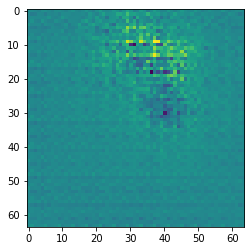

In [36]:
from matplotlib import pyplot as plt
plt.imshow(fake[0,:,:,0].cpu().detach().numpy())

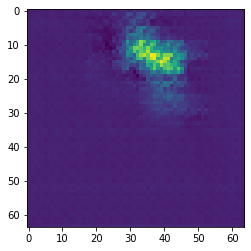

In [37]:
plt.imshow(fake[0,:,:,5].cpu().detach().numpy())

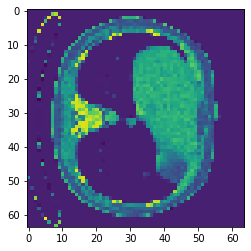

In [38]:
plt.imshow(X[0,:,:,0].cpu().detach().numpy())

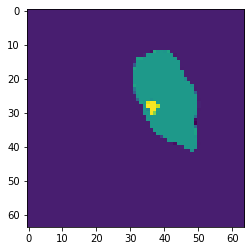

In [39]:
plt.imshow(X[0,:,:,5].cpu().detach().numpy())